# Importing the modules

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import scipy.io as sio

In [30]:
import hvplot
import hvplot.pandas
pd.options.plotting.backend = 'hvplot'

# Loading the dataset

In [31]:
def loadPaviaUData():
    data_path = os.path.join('F:\main_project\Datasets')
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [32]:
Dataset, groundTruth=loadPaviaUData()

# Extraction of pixels

In [33]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [34]:
df = extract_pixels(Dataset, groundTruth)

100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [00:04<00:00, 24.33it/s]


In [35]:
df.to_csv('Dataset.csv', index=False)

In [36]:
df = pd.read_csv('Dataset.csv')

In [37]:
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-95,band-96,band-97,band-98,band-99,band-100,band-101,band-102,band-103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [38]:
Dataset = df.iloc[:, :-1].values

groundTruth = df.iloc[:, -1].values

In [39]:
Dataset.shape, groundTruth.shape

((207400, 103), (207400,))

# Dimensionality Reduction

In [40]:
pca = PCA(n_components = 70)

principalComponents = pca.fit_transform(Dataset)

ev=pca.explained_variance_ratio_

# Splitting the dataset

In [41]:
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, groundTruth,  range(Dataset.shape[0]), 
                                                                                  test_size = 0.25, random_state = 11)

In [42]:
X_train.shape, X_test.shape

((155550, 70), (51850, 70))

In [43]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Applying Random Forest Classifier

In [44]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [45]:
y_pred = classifier.predict(X_test)

# Performance Evalution

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score,accuracy_score

In [47]:
classification=classification_report(y_test,y_pred)
confusion=confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test,y_pred)
overall_accuracy=accuracy_score(y_test, y_pred)
avgAcc=[]
classArray=[]
for c in range(len(confusion)):
    recallSoc=confusion[c][c]/sum(confusion[c])
    classArray+=[recallSoc]
avgAcc.append(sum(classArray)/len(classArray))
Average_accuracy=np.mean(avgAcc)

In [48]:
print('Classification_report:\n')
print('{}\n'.format(classification))
print('Confusion_matrix :\n')
print('{}\n'.format(confusion))
print('Kappa value : {}\n'.format(kappa))
print('Average_accuracy : {}\n'.format(Average_accuracy))
print('overall_Accuracy={}'.format(overall_accuracy))

Classification_report:

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     41146
           1       0.50      0.08      0.13      1641
           2       0.71      0.30      0.42      4640
           3       0.54      0.09      0.15       534
           4       0.59      0.06      0.11       759
           5       0.82      0.81      0.82       355
           6       0.62      0.03      0.05      1221
           7       0.78      0.18      0.30       339
           8       0.52      0.10      0.16       972
           9       0.59      0.04      0.08       243

    accuracy                           0.82     51850
   macro avg       0.65      0.27      0.31     51850
weighted avg       0.79      0.82      0.77     51850


Confusion_matrix :

[[40233   118   552    31    33    65    19    16    72     7]
 [ 1513   126     0     0     0     0     0     1     1     0]
 [ 3243     0  1395     0     1     0     1     0     0     0]
 [  474

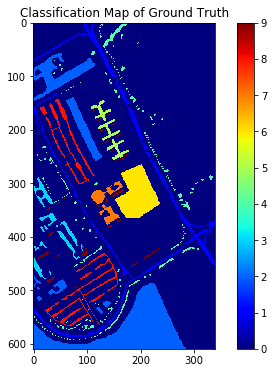

In [49]:
plt.figure(figsize=(8, 6))
plt.imshow(df.iloc[:, -1].values.reshape((610, 340)), cmap='jet')
plt.colorbar()
plt.title('Classification Map of Ground Truth')
plt.savefig('ground_truth.png')
plt.show()

In [50]:
from tqdm import tqdm
pre = y_pred

clmap = [0]*Dataset.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = groundTruth[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|████████████████████████████████████████████████████████████████████████| 51850/51850 [00:00<00:00, 834383.93it/s]


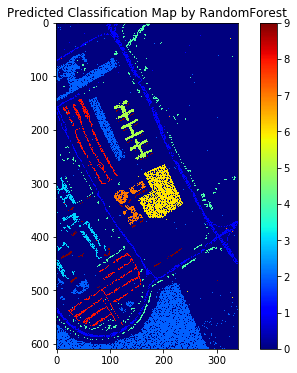

In [51]:
plt.figure(figsize=(8, 6))
plt.imshow(np.array(clmap).reshape((610, 340)), cmap='jet')
plt.colorbar()
plt.title('Predicted Classification Map by RandomForest')
plt.savefig('Classification_map.png')
plt.show()

In [52]:
df.count()

band-1      207400
band-2      207400
band-3      207400
band-4      207400
band-5      207400
             ...  
band-100    207400
band-101    207400
band-102    207400
band-103    207400
class       207400
Length: 104, dtype: int64

In [53]:
df.loc[:, 'class'].value_counts()

0    164624
2     18649
1      6631
6      5029
8      3682
4      3064
3      2099
5      1345
7      1330
9       947
Name: class, dtype: int64

In [54]:
df[df['class']== 9][0:1000]

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-95,band-96,band-97,band-98,band-99,band-100,band-101,band-102,band-103,class
51815,700,758,804,700,612,615,640,653,686,693,...,463,493,534,558,542,545,553,511,480,9
51816,640,608,481,509,635,597,475,428,424,384,...,539,558,619,623,593,584,585,592,599,9
52154,977,706,523,327,307,403,387,346,404,442,...,500,511,551,558,580,592,600,584,578,9
52155,722,383,272,364,461,490,498,412,322,293,...,631,603,602,627,627,607,596,614,611,9
52156,515,207,254,479,571,420,365,380,342,336,...,670,663,654,683,712,724,725,704,647,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168040,754,695,487,520,500,512,520,489,429,403,...,394,385,396,436,459,437,402,365,331,9
168377,1009,786,663,623,589,561,507,437,417,423,...,408,397,425,443,428,399,370,377,400,9
168378,695,789,646,547,507,517,495,447,441,482,...,428,410,419,457,439,437,461,445,432,9
168379,608,622,577,593,617,584,586,532,466,458,...,413,402,455,511,513,501,471,438,424,9


In [55]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 104), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

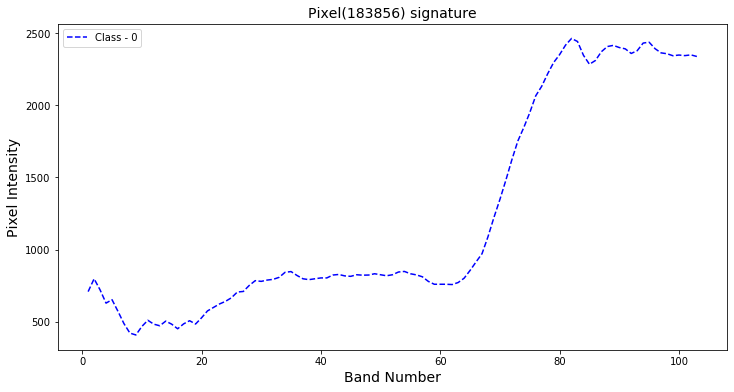

In [56]:
plot_signature(df)